## Test PSF measurement in the stack

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

24


Make a couple of test images to test the PSF measurement on...

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

See `pipe_tasks/examples/measurePsfTask.py`.

In [3]:
import lsst.pipe.tasks.measurePsf as measurePsf
import lsst.afw.table as afwTable
import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)

exp = testObj.im1.asAfwExposure()
sources = dit.doDetection(exp, asDF=False)

In [4]:
config = measurePsf.MeasurePsfConfig()
schema = afwTable.SourceTable.makeMinimalSchema()

psfDeterminer = config.psfDeterminer.apply()
psfDeterminer.config.sizeCellX = 128
psfDeterminer.config.sizeCellY = 128
psfDeterminer.config.spatialOrder = 1
psfDeterminer.config.nEigenComponents = 3
task = measurePsf.MeasurePsfTask(schema=schema, config=config)

result = task.run(exp, sources)
psf = result.psf
cellSet = result.cellSet

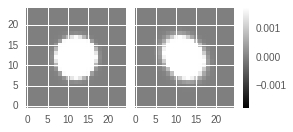

In [5]:
dit.plotImageGrid((testObj.im1.psf, testObj.im2.psf))

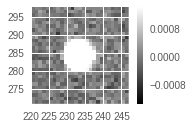

In [6]:
dit.plotImageGrid((psf.computeImage(),)) #, clim=(-0.001,0.001))

In [7]:
def measurePsf(exp):
    import lsst.pipe.tasks.measurePsf as measurePsf
    import lsst.afw.table as afwTable
    import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)
    import lsst.meas.algorithms        as measAlg

    # The old (meas_algorithms) SdssCentroid assumed this by default if it
    # wasn't specified; meas_base requires us to be explicit.
    psf = measAlg.DoubleGaussianPsf(11, 11, 0.01)
    exp.setPsf(psf)

    im = exp.getMaskedImage().getImage()
    im -= np.median(im.getArray())

    sources = dit.doDetection(exp, asDF=False)
    config = measurePsf.MeasurePsfConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()

    psfDeterminer = config.psfDeterminer.apply()
    psfDeterminer.config.sizeCellX = 128
    psfDeterminer.config.sizeCellY = 128
    psfDeterminer.config.spatialOrder = 1
    psfDeterminer.config.nEigenComponents = 3
    task = measurePsf.MeasurePsfTask(schema=schema, config=config)

    result = task.run(exp, sources)
    return result

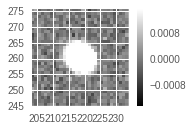

In [8]:
res = measurePsf(testObj.im2.asAfwExposure())
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

(25, 25) (41, 41)
1.0000003546


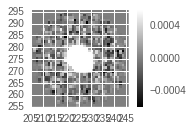

In [9]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

(25, 25) (31, 31)
0.999945573135


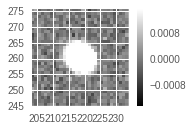

In [10]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

See how it works on a *really* crowded field.

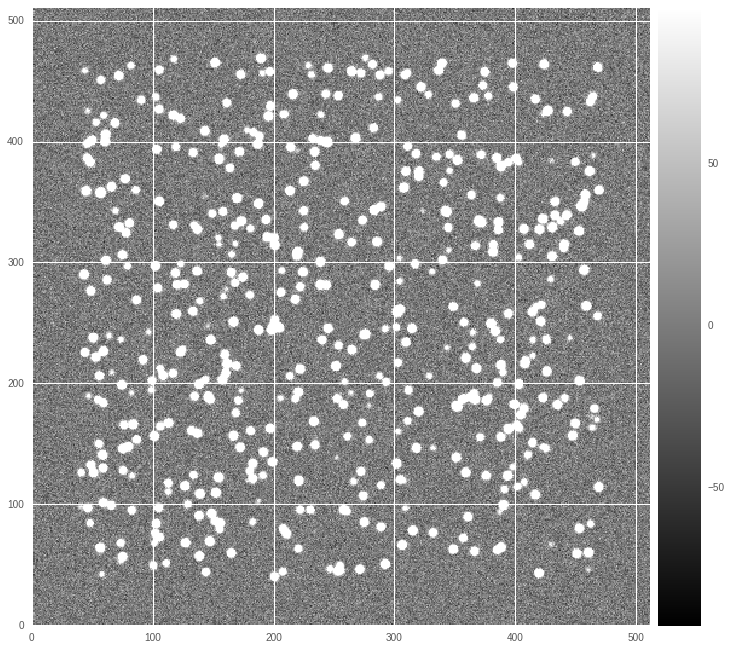

In [87]:
reload(dit)
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=500, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj2.im1.im,))

(25, 25) (41, 41)
0.999999898476


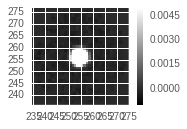

In [88]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')
psf1 = res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()
dit.plotImageGrid((psf1,), clim=(-0.001,0.005))

1.0


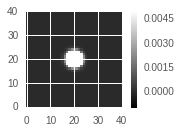

In [89]:
actualPsf1 = dit.makePsf(21, [1.6, 1.6], theta=0.)
dit.plotImageGrid((actualPsf1,), clim=(-0.001,0.005))
print actualPsf1.sum()

(20, 20)
(20, 20)
0.119716513885


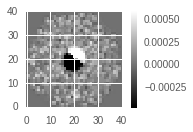

In [90]:
print np.unravel_index(np.argmax(psf1.getArray()), psf1.getArray().shape)
print np.unravel_index(np.argmax(actualPsf1), actualPsf1.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf1.getArray() - actualPsf1)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb
dit.plotImageGrid((actualPsf1 - psf1.getArray(),))

(25, 25) (41, 41)
0.999999621875


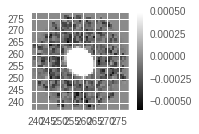

In [91]:
res = dit.measurePsf(testObj2.im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
psf2 = res.psf.computeImage()
print testObj2.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))

1.0


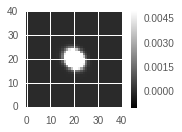

In [92]:
actualPsf2 = dit.makePsf(21, [1.8, 2.2], theta=-45.)
dit.plotImageGrid((actualPsf2,), clim=(-0.001,0.005))
print actualPsf2.sum()

(20, 20)
(20, 20)
0.0833607714775


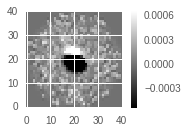

In [93]:
print np.unravel_index(np.argmax(psf2.getArray()), psf2.getArray().shape)
print np.unravel_index(np.argmax(actualPsf2), actualPsf2.shape)
print np.sqrt(((psf2.getArray() - actualPsf2)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb
dit.plotImageGrid((actualPsf2 - psf2.getArray(),))

In [94]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1, scint=0., measuredPsf=None):
    try:
        #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                                 offset=[0,0], psf_yvary_factor=0., 
                                 scintillation=scint,
                                 varFlux2=np.repeat(flux, n_varSources),
                                 theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                                 sourceFluxRange=(500,30000), seed=seed, psfSize=21)
        #testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)
        #ppm = 1.0 + percentagePsfMismeasure / 100.
        origPsf = testObj.im2.psf
        testObj.im2.psf = measuredPsf #dit.makePsf(psfSize=13, sigma=[1.8*ppm,2.2*ppm], theta=-45.*ppm)
        det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
        det['flux'] = flux
        #det['ppm'] = percentagePsfMismeasure
        det['rms'] = np.sqrt(((origPsf - testObj.im2.psf)**2.).mean())
        #print percentagePsfMismeasure, det['rms']
        return det
    except Exception as e:
        print(e)
        pass
    return None

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

In [97]:
psf2input = psf2.getArray()
inputs = [(f, seed) for f in [1500] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10, \
                                                                      scint=0.1, measuredPsf=psf2input) \
                                                     for i in inputs)

100


[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:  1.6min finished


FN: 
ALstack             1.80
ALstack_noDecorr    1.81
SZOGY               2.85
ZOGY                2.28
dtype: float64
FP: 
ALstack             19.52
ALstack_noDecorr    20.17
SZOGY               39.99
ZOGY                71.46
dtype: float64
TP: 
ALstack             8.18
ALstack_noDecorr    8.17
SZOGY               7.13
ZOGY                7.70
dtype: float64


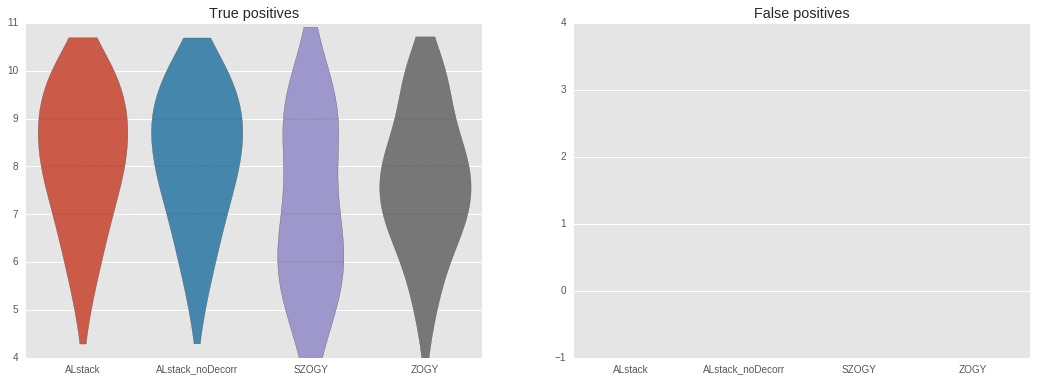

In [98]:
def plotResults(tr):
    tr = [t for t in tr if t is not None]
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    axes[0].set_ylim((4, 11))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    axes[1].set_ylim((-1, 4))
    
plotResults(testResults1)

Try a really sparse field.

[[   429.40377321     49.59226944   6742.90839861   6742.90839861]
 [   261.72846073    372.31941309      0.           1500.        ]
 [   272.35445943     61.21064062  12473.85031986  12473.85031986]
 [   326.32515954    240.51121657      0.           1500.        ]
 [   313.27846152    445.67145029   7847.37657668   7847.37657668]
 [   192.32379077    133.31680266      0.           1500.        ]
 [    51.48292303    195.72825837  23356.45076723  23356.45076723]
 [   111.23992084     53.49833047  17834.51121296  17834.51121296]
 [   418.98648529    171.04319442  16657.08024209  16657.08024209]
 [    69.23061647    121.14336757  15364.49621383  15364.49621383]
 [   199.07598062     94.3748016    4897.34009925   4897.34009925]
 [    89.78075273    218.52745544  25300.12466264  25300.12466264]
 [    81.5027755     447.15324488  10712.61537283  10712.61537283]
 [    76.10473972     56.52605549   3362.01195937   3362.01195937]
 [    77.46554871    452.48427913  21145.15830741  21145.15830

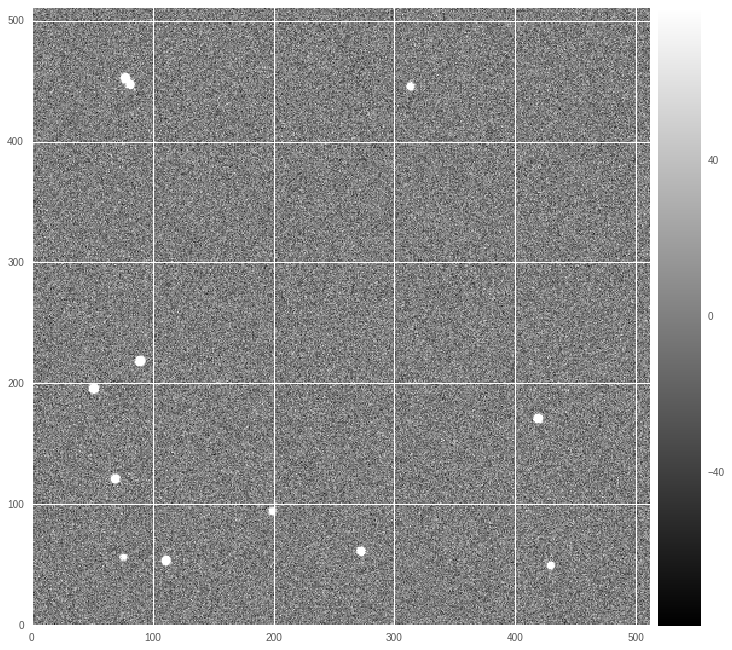

In [14]:
testObj3 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=15, sourceFluxRange=(2500,30000), 
                         seed=66, psfSize=13)

print testObj3.centroids
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj3.im1.im,))

(25, 25) (41, 41)
0.999999885711


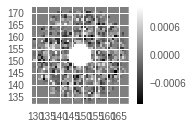

In [15]:
reload(dit)
res = dit.measurePsf(testObj3.im1.asAfwExposure(), measurePsfAlg='psfex')
psf1 = res.psf.computeImage()
print testObj3.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()
dit.plotImageGrid((psf1,)) #, clim=(-0.001,0.001))

(25, 25) (41, 41)
0.99999979827


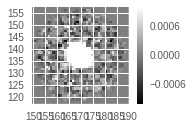

In [16]:
res = dit.measurePsf(testObj3.im2.asAfwExposure(), measurePsfAlg='psfex')
psf2 = res.psf.computeImage()
print testObj3.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))

Just an update where we speed up the makeFakeImages by ~10x...

In [53]:
reload(dit)

testObj2a = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

(0.0, 0.0, 0.0, 0.0)


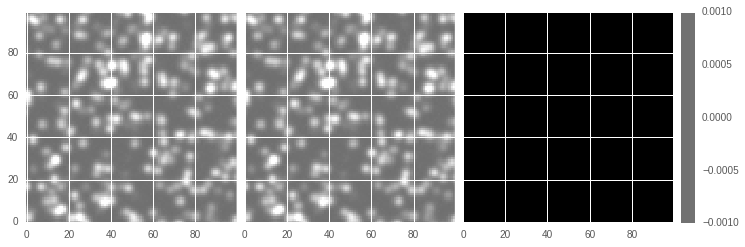

In [54]:
fig = plt.figure(1, (12, 12))
print dit.computeClippedImageStats(testObj2.im1.im-testObj2a.im1.im)
dit.plotImageGrid((testObj2.im1.im[200:300,200:300], 
                   testObj2a.im1.im[200:300,200:300], (testObj2.im1.im-testObj2a.im1.im)[200:300,200:300]))

(0.0, 0.0, 0.0, 0.0)


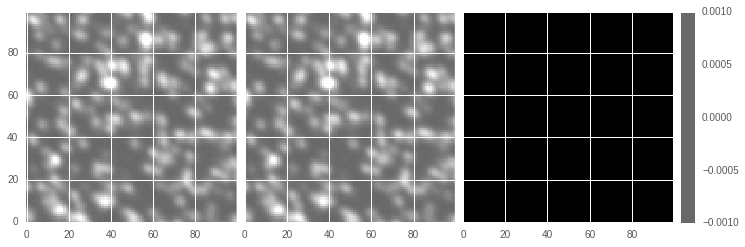

In [55]:
fig = plt.figure(1, (12, 12))
print dit.computeClippedImageStats(testObj2.im2.im-testObj2a.im2.im)
dit.plotImageGrid((testObj2.im2.im[200:300,200:300], 
                   testObj2a.im2.im[200:300,200:300], (testObj2.im2.im-testObj2a.im2.im)[200:300,200:300]))